<a href="https://colab.research.google.com/github/abhizc/EVA4-B2/blob/master/S6/Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import OneCycleLR

In [2]:
from google.colab import files
files.upload()

Saving models.py to models.py


{'models.py': b"dropout_value = 0.05\n\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\nimport torch.optim as optim\nfrom torchvision import datasets, transforms\n\nclass BatchNorm(nn.BatchNorm2d):\n    def __init__(self, num_features, eps=1e-05, momentum=0.1, weight=True, bias=True):\n        super().__init__(num_features, eps=eps, momentum=momentum)\n        self.weight.data.fill_(1.0)\n        self.bias.data.fill_(0.0)\n        self.weight.requires_grad = weight\n        self.bias.requires_grad = bias\n\n\nclass GhostBatchNorm(BatchNorm):\n    def __init__(self, num_features, num_splits, **kw):\n        super().__init__(num_features, **kw)\n        self.num_splits = num_splits\n        self.register_buffer('running_mean', torch.zeros(num_features * self.num_splits))\n        self.register_buffer('running_var', torch.ones(num_features * self.num_splits))\n\n    def train(self, mode=True):\n        if (self.training is True) and (mode is False):  # lazily collate

# Data Transformations


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=256, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The Model

In [0]:
from models import *

# Model Params

Viewing model summary is important. There is no in-built model visualizer in pyTorch. take external help from torychsummary.

In [9]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model_BN = Net_BN().to(device)
summary(model_BN, input_size=(1, 28, 28))

model_GBN = Net_GBN().to(device)
summary(model_GBN, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
           Dropout-3           [-1, 10, 28, 28]               0
              ReLU-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             900
       BatchNorm2d-6           [-1, 10, 28, 28]              20
           Dropout-7           [-1, 10, 28, 28]               0
              ReLU-8           [-1, 10, 28, 28]               0
         MaxPool2d-9           [-1, 10, 14, 14]               0
           Conv2d-10           [-1, 10, 12, 12]             900
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm
import numpy as np

class ModelTrain():
  def __init__(self):
    #to monitor training and test losses
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    # initialize tracker for minimum validation loss
    self.valid_loss_min = np.Inf # set initial "min" to infinity

  def train(self, model, device, train_loader, optimizer, epoch,scheduler, L1lambda=None):
    model.train()    # prep model for training
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()    # clear the gradients of all optimized variables
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)   # forward pass: compute predicted outputs by passing inputs to the model

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 regularization
      if L1lambda is not None:
        #l1_crit = nn.L1Loss(size_average=False)
        reg_loss = 0.
        for param in model.parameters():
          #reg_loss += l1_crit(param)
          reg_loss += torch.sum(param.abs())
        loss += L1lambda * reg_loss

      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      optimizer.step()   # perform a single optimization step (parameter update)

      # Update pbar-tqdm
    
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
      scheduler.step()
    self.train_epoch_end.append(self.train_acc[-1])


  ####VAlidate the model ####
  def test(self, model, device, test_loader,filename):
    #valid_loss_min = np.Inf
    model.eval()  # prep model for evaluation
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # forward pass: compute predicted outputs by passing inputs to the model
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    self.test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    self.test_acc.append(100. * correct / len(test_loader.dataset))

    # save model if validation loss has decreased
    if test_loss <= self.valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        self.valid_loss_min,
        test_loss))
        torch.save(model.state_dict(), filename)
        self.valid_loss_min = test_loss


# BN
## Model without L1 and L2 regularizations

In [11]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net_BN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=10)

#first model
#without L1 and L2 regularization
model1 = ModelTrain()
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model1.train(model, device, train_loader, optimizer, epoch, scheduler)
    model1.test(model, device, test_loader,"model1.pt")

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.08834461122751236 Batch_id=234 Accuracy=69.05: 100%|██████████| 235/235 [00:11<00:00, 19.74it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1234, Accuracy: 9681/10000 (96.81%)

Validation loss decreased (inf --> 0.123422).  Saving model ...
EPOCH: 1


Loss=0.13325856626033783 Batch_id=234 Accuracy=97.36: 100%|██████████| 235/235 [00:11<00:00, 19.73it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9844/10000 (98.44%)

Validation loss decreased (0.123422 --> 0.048858).  Saving model ...
EPOCH: 2


Loss=0.08721081167459488 Batch_id=234 Accuracy=98.02: 100%|██████████| 235/235 [00:11<00:00, 19.84it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9899/10000 (98.99%)

Validation loss decreased (0.048858 --> 0.037033).  Saving model ...
EPOCH: 3


Loss=0.011784265749156475 Batch_id=234 Accuracy=98.35: 100%|██████████| 235/235 [00:12<00:00, 19.41it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Accuracy: 9917/10000 (99.17%)

Validation loss decreased (0.037033 --> 0.025983).  Saving model ...
EPOCH: 4


Loss=0.029909953474998474 Batch_id=234 Accuracy=98.55: 100%|██████████| 235/235 [00:11<00:00, 19.92it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.016803324222564697 Batch_id=234 Accuracy=98.74: 100%|██████████| 235/235 [00:12<00:00, 19.56it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9934/10000 (99.34%)

Validation loss decreased (0.025983 --> 0.020219).  Saving model ...
EPOCH: 6


Loss=0.03817739710211754 Batch_id=234 Accuracy=98.83: 100%|██████████| 235/235 [00:12<00:00, 19.38it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0181, Accuracy: 9942/10000 (99.42%)

Validation loss decreased (0.020219 --> 0.018129).  Saving model ...
EPOCH: 7


Loss=0.030516142025589943 Batch_id=234 Accuracy=98.98: 100%|██████████| 235/235 [00:11<00:00, 20.07it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9943/10000 (99.43%)

Validation loss decreased (0.018129 --> 0.017348).  Saving model ...
EPOCH: 8


Loss=0.013685340993106365 Batch_id=234 Accuracy=99.08: 100%|██████████| 235/235 [00:12<00:00, 19.44it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0156, Accuracy: 9947/10000 (99.47%)

Validation loss decreased (0.017348 --> 0.015612).  Saving model ...
EPOCH: 9


Loss=0.03423328325152397 Batch_id=234 Accuracy=99.15: 100%|██████████| 235/235 [00:11<00:00, 19.67it/s]



Test set: Average loss: 0.0144, Accuracy: 9952/10000 (99.52%)

Validation loss decreased (0.015612 --> 0.014426).  Saving model ...


# Model with L1 Regualrization

In [12]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net_BN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=10)

#2 model
#with L1 regularization
model2 = ModelTrain()
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model2.train(model, device, train_loader, optimizer, epoch, scheduler,L1lambda=1e-5)
    model2.test(model, device, test_loader,"model2.pt")

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.22907420992851257 Batch_id=234 Accuracy=69.63: 100%|██████████| 235/235 [00:12<00:00, 18.96it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1048, Accuracy: 9724/10000 (97.24%)

Validation loss decreased (inf --> 0.104833).  Saving model ...
EPOCH: 1


Loss=0.12813961505889893 Batch_id=234 Accuracy=97.32: 100%|██████████| 235/235 [00:12<00:00, 18.55it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9878/10000 (98.78%)

Validation loss decreased (0.104833 --> 0.043172).  Saving model ...
EPOCH: 2


Loss=0.15478397905826569 Batch_id=234 Accuracy=98.01: 100%|██████████| 235/235 [00:12<00:00, 18.55it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Accuracy: 9897/10000 (98.97%)

Validation loss decreased (0.043172 --> 0.036078).  Saving model ...
EPOCH: 3


Loss=0.046441905200481415 Batch_id=234 Accuracy=98.31: 100%|██████████| 235/235 [00:12<00:00, 18.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9900/10000 (99.00%)

Validation loss decreased (0.036078 --> 0.030735).  Saving model ...
EPOCH: 4


Loss=0.03908638283610344 Batch_id=234 Accuracy=98.57: 100%|██████████| 235/235 [00:12<00:00, 18.50it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9917/10000 (99.17%)

Validation loss decreased (0.030735 --> 0.027321).  Saving model ...
EPOCH: 5


Loss=0.02319435030221939 Batch_id=234 Accuracy=98.69: 100%|██████████| 235/235 [00:12<00:00, 18.57it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9945/10000 (99.45%)

Validation loss decreased (0.027321 --> 0.021526).  Saving model ...
EPOCH: 6


Loss=0.023525036871433258 Batch_id=234 Accuracy=98.84: 100%|██████████| 235/235 [00:12<00:00, 18.67it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)

EPOCH: 7


Loss=0.016770627349615097 Batch_id=234 Accuracy=98.97: 100%|██████████| 235/235 [00:12<00:00, 18.51it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0161, Accuracy: 9951/10000 (99.51%)

Validation loss decreased (0.021526 --> 0.016124).  Saving model ...
EPOCH: 8


Loss=0.0494590699672699 Batch_id=234 Accuracy=99.11: 100%|██████████| 235/235 [00:12<00:00, 18.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0164, Accuracy: 9946/10000 (99.46%)

EPOCH: 9


Loss=0.01335120014846325 Batch_id=234 Accuracy=99.22: 100%|██████████| 235/235 [00:12<00:00, 18.44it/s]



Test set: Average loss: 0.0148, Accuracy: 9952/10000 (99.52%)

Validation loss decreased (0.016124 --> 0.014791).  Saving model ...


# Model with L2 Regularization

In [13]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net_BN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=10)

#3 model
#without L1 and L2 regularization
model3 = ModelTrain()
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model3.train(model, device, train_loader, optimizer, epoch, scheduler)
    model3.test(model, device, test_loader,"model3.pt")

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.18137800693511963 Batch_id=234 Accuracy=75.17: 100%|██████████| 235/235 [00:11<00:00, 19.81it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1105, Accuracy: 9679/10000 (96.79%)

Validation loss decreased (inf --> 0.110478).  Saving model ...
EPOCH: 1


Loss=0.06478764861822128 Batch_id=234 Accuracy=97.31: 100%|██████████| 235/235 [00:12<00:00, 19.45it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0481, Accuracy: 9849/10000 (98.49%)

Validation loss decreased (0.110478 --> 0.048118).  Saving model ...
EPOCH: 2


Loss=0.08548607677221298 Batch_id=234 Accuracy=98.10: 100%|██████████| 235/235 [00:12<00:00, 19.29it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9891/10000 (98.91%)

Validation loss decreased (0.048118 --> 0.033222).  Saving model ...
EPOCH: 3


Loss=0.022029990330338478 Batch_id=234 Accuracy=98.44: 100%|██████████| 235/235 [00:12<00:00, 19.51it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9907/10000 (99.07%)

Validation loss decreased (0.033222 --> 0.027958).  Saving model ...
EPOCH: 4


Loss=0.011199037544429302 Batch_id=234 Accuracy=98.58: 100%|██████████| 235/235 [00:12<00:00, 19.45it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9931/10000 (99.31%)

Validation loss decreased (0.027958 --> 0.021784).  Saving model ...
EPOCH: 5


Loss=0.05457392334938049 Batch_id=234 Accuracy=98.76: 100%|██████████| 235/235 [00:12<00:00, 19.36it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9937/10000 (99.37%)

Validation loss decreased (0.021784 --> 0.021025).  Saving model ...
EPOCH: 6


Loss=0.04588797688484192 Batch_id=234 Accuracy=98.85: 100%|██████████| 235/235 [00:12<00:00, 19.48it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9937/10000 (99.37%)

Validation loss decreased (0.021025 --> 0.020228).  Saving model ...
EPOCH: 7


Loss=0.03904115781188011 Batch_id=234 Accuracy=99.03: 100%|██████████| 235/235 [00:11<00:00, 19.74it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9936/10000 (99.36%)

Validation loss decreased (0.020228 --> 0.019660).  Saving model ...
EPOCH: 8


Loss=0.015236993320286274 Batch_id=234 Accuracy=99.13: 100%|██████████| 235/235 [00:11<00:00, 19.66it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0170, Accuracy: 9941/10000 (99.41%)

Validation loss decreased (0.019660 --> 0.017025).  Saving model ...
EPOCH: 9


Loss=0.020830653607845306 Batch_id=234 Accuracy=99.22: 100%|██████████| 235/235 [00:12<00:00, 19.39it/s]



Test set: Average loss: 0.0165, Accuracy: 9951/10000 (99.51%)

Validation loss decreased (0.017025 --> 0.016547).  Saving model ...


# Model with L1 and L2 regularization 

In [14]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net_BN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=10)

#4 model
#without L1 and L2 regularization
model4 = ModelTrain()
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model4.train(model, device, train_loader, optimizer, epoch, scheduler,L1lambda=1e-5)
    model4.test(model, device, test_loader,"model4.pt")

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10999889671802521 Batch_id=234 Accuracy=72.87: 100%|██████████| 235/235 [00:12<00:00, 18.72it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1067, Accuracy: 9688/10000 (96.88%)

Validation loss decreased (inf --> 0.106738).  Saving model ...
EPOCH: 1


Loss=0.08653829246759415 Batch_id=234 Accuracy=97.33: 100%|██████████| 235/235 [00:12<00:00, 19.19it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9885/10000 (98.85%)

Validation loss decreased (0.106738 --> 0.038214).  Saving model ...
EPOCH: 2


Loss=0.07233359664678574 Batch_id=234 Accuracy=98.08: 100%|██████████| 235/235 [00:12<00:00, 19.05it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9865/10000 (98.65%)

EPOCH: 3


Loss=0.07256074994802475 Batch_id=234 Accuracy=98.44: 100%|██████████| 235/235 [00:12<00:00, 18.67it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

Validation loss decreased (0.038214 --> 0.026592).  Saving model ...
EPOCH: 4


Loss=0.052848074585199356 Batch_id=234 Accuracy=98.56: 100%|██████████| 235/235 [00:12<00:00, 18.96it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.07705425471067429 Batch_id=234 Accuracy=98.66: 100%|██████████| 235/235 [00:12<00:00, 18.79it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9929/10000 (99.29%)

Validation loss decreased (0.026592 --> 0.019957).  Saving model ...
EPOCH: 6


Loss=0.06314080208539963 Batch_id=234 Accuracy=98.82: 100%|██████████| 235/235 [00:12<00:00, 18.62it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9927/10000 (99.27%)

EPOCH: 7


Loss=0.09987081587314606 Batch_id=234 Accuracy=98.97: 100%|██████████| 235/235 [00:12<00:00, 18.80it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9943/10000 (99.43%)

Validation loss decreased (0.019957 --> 0.017384).  Saving model ...
EPOCH: 8


Loss=0.0254107266664505 Batch_id=234 Accuracy=99.12: 100%|██████████| 235/235 [00:12<00:00, 18.56it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0138, Accuracy: 9958/10000 (99.58%)

Validation loss decreased (0.017384 --> 0.013820).  Saving model ...
EPOCH: 9


Loss=0.028348837047815323 Batch_id=234 Accuracy=99.23: 100%|██████████| 235/235 [00:12<00:00, 18.85it/s]



Test set: Average loss: 0.0132, Accuracy: 9960/10000 (99.60%)

Validation loss decreased (0.013820 --> 0.013202).  Saving model ...



# GBN
## Model without L1 and L2 regularizations

In [15]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net_GBN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=10)

#first model
#without L1 and L2 regularization
model5 = ModelTrain()
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model1.train(model, device, train_loader, optimizer, epoch, scheduler)
    model1.test(model, device, test_loader,"model5.pt")

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.14365296065807343 Batch_id=234 Accuracy=71.72: 100%|██████████| 235/235 [00:11<00:00, 19.86it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1274, Accuracy: 9649/10000 (96.49%)

EPOCH: 1


Loss=0.11777593940496445 Batch_id=234 Accuracy=97.49: 100%|██████████| 235/235 [00:11<00:00, 19.97it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0467, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.03652997687458992 Batch_id=234 Accuracy=98.12: 100%|██████████| 235/235 [00:11<00:00, 19.66it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Loss=0.09483245760202408 Batch_id=234 Accuracy=98.38: 100%|██████████| 235/235 [00:12<00:00, 19.53it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9896/10000 (98.96%)

EPOCH: 4


Loss=0.02346663735806942 Batch_id=234 Accuracy=98.62: 100%|██████████| 235/235 [00:11<00:00, 19.64it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.09863030910491943 Batch_id=234 Accuracy=98.71: 100%|██████████| 235/235 [00:11<00:00, 19.97it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9887/10000 (98.87%)

EPOCH: 6


Loss=0.016433099284768105 Batch_id=234 Accuracy=98.86: 100%|██████████| 235/235 [00:11<00:00, 20.58it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9934/10000 (99.34%)

EPOCH: 7


Loss=0.047987569123506546 Batch_id=234 Accuracy=99.04: 100%|██████████| 235/235 [00:11<00:00, 19.90it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0189, Accuracy: 9940/10000 (99.40%)

EPOCH: 8


Loss=0.013593356125056744 Batch_id=234 Accuracy=99.10: 100%|██████████| 235/235 [00:11<00:00, 20.23it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9936/10000 (99.36%)

EPOCH: 9


Loss=0.03908545896410942 Batch_id=234 Accuracy=99.20: 100%|██████████| 235/235 [00:11<00:00, 19.92it/s]



Test set: Average loss: 0.0165, Accuracy: 9947/10000 (99.47%)



# Model with L1 Regualrization

In [16]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net_GBN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=10)

#2 model
#with L1 regularization
model6 = ModelTrain()
EPOCHS =10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model2.train(model, device, train_loader, optimizer, epoch, scheduler,L1lambda=1e-5)
    model2.test(model, device, test_loader,"model6.pt")

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10644684731960297 Batch_id=234 Accuracy=72.00: 100%|██████████| 235/235 [00:12<00:00, 19.41it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0990, Accuracy: 9733/10000 (97.33%)

EPOCH: 1


Loss=0.06097601726651192 Batch_id=234 Accuracy=97.25: 100%|██████████| 235/235 [00:12<00:00, 19.23it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0683, Accuracy: 9788/10000 (97.88%)

EPOCH: 2


Loss=0.046723876148462296 Batch_id=234 Accuracy=97.97: 100%|██████████| 235/235 [00:12<00:00, 19.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0321, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.09284519404172897 Batch_id=234 Accuracy=98.24: 100%|██████████| 235/235 [00:12<00:00, 19.45it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0374, Accuracy: 9875/10000 (98.75%)

EPOCH: 4


Loss=0.08613275736570358 Batch_id=234 Accuracy=98.54: 100%|██████████| 235/235 [00:11<00:00, 19.94it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9922/10000 (99.22%)

EPOCH: 5


Loss=0.1851569265127182 Batch_id=234 Accuracy=98.73: 100%|██████████| 235/235 [00:11<00:00, 20.69it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9921/10000 (99.21%)

EPOCH: 6


Loss=0.12657570838928223 Batch_id=234 Accuracy=98.76: 100%|██████████| 235/235 [00:11<00:00, 19.97it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9930/10000 (99.30%)

EPOCH: 7


Loss=0.04180506244301796 Batch_id=234 Accuracy=98.95: 100%|██████████| 235/235 [00:11<00:00, 19.93it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0172, Accuracy: 9945/10000 (99.45%)

EPOCH: 8


Loss=0.013838800601661205 Batch_id=234 Accuracy=99.02: 100%|██████████| 235/235 [00:11<00:00, 19.60it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0165, Accuracy: 9942/10000 (99.42%)

EPOCH: 9


Loss=0.05232562869787216 Batch_id=234 Accuracy=99.18: 100%|██████████| 235/235 [00:12<00:00, 19.30it/s]



Test set: Average loss: 0.0156, Accuracy: 9944/10000 (99.44%)



# Model with L2 Regularization

In [17]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net_GBN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=10)

#3 model
#without L1 and L2 regularization
model7 = ModelTrain()
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model3.train(model, device, train_loader, optimizer, epoch, scheduler)
    model3.test(model, device, test_loader,"model7.pt")

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10043308883905411 Batch_id=234 Accuracy=75.73: 100%|██████████| 235/235 [00:11<00:00, 20.68it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1435, Accuracy: 9586/10000 (95.86%)

EPOCH: 1


Loss=0.2107149362564087 Batch_id=234 Accuracy=97.04: 100%|██████████| 235/235 [00:11<00:00, 20.05it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9855/10000 (98.55%)

EPOCH: 2


Loss=0.04057794809341431 Batch_id=234 Accuracy=97.91: 100%|██████████| 235/235 [00:11<00:00, 20.65it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.016776427626609802 Batch_id=234 Accuracy=98.36: 100%|██████████| 235/235 [00:11<00:00, 20.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.028793834149837494 Batch_id=234 Accuracy=98.42: 100%|██████████| 235/235 [00:11<00:00, 20.41it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0308, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.04459317401051521 Batch_id=234 Accuracy=98.60: 100%|██████████| 235/235 [00:11<00:00, 19.73it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.03474991396069527 Batch_id=234 Accuracy=98.85: 100%|██████████| 235/235 [00:11<00:00, 20.00it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 7


Loss=0.047683317214250565 Batch_id=234 Accuracy=98.89: 100%|██████████| 235/235 [00:11<00:00, 20.37it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.08056631684303284 Batch_id=234 Accuracy=99.02: 100%|██████████| 235/235 [00:11<00:00, 20.28it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 9954/10000 (99.54%)

Validation loss decreased (0.016547 --> 0.015285).  Saving model ...
EPOCH: 9


Loss=0.03712344169616699 Batch_id=234 Accuracy=99.14: 100%|██████████| 235/235 [00:11<00:00, 19.94it/s]



Test set: Average loss: 0.0153, Accuracy: 9945/10000 (99.45%)



# Model with L1 and L2 regularization 

In [18]:
#from torch.optim.lr_scheduler import StepLR

from torch.optim.lr_scheduler import OneCycleLR
model =  Net_GBN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=10)

#4 model
#without L1 and L2 regularization
model8 = ModelTrain()
EPOCHS = 10
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model4.train(model, device, train_loader, optimizer, epoch, scheduler,L1lambda=1e-5)
    model4.test(model, device, test_loader,"model8.pt")

  0%|          | 0/235 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.20826594531536102 Batch_id=234 Accuracy=70.38: 100%|██████████| 235/235 [00:12<00:00, 19.04it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.1051, Accuracy: 9698/10000 (96.98%)

EPOCH: 1


Loss=0.0779307410120964 Batch_id=234 Accuracy=97.19: 100%|██████████| 235/235 [00:12<00:00, 19.04it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9861/10000 (98.61%)

EPOCH: 2


Loss=0.2277866154909134 Batch_id=234 Accuracy=97.97: 100%|██████████| 235/235 [00:12<00:00, 19.18it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9848/10000 (98.48%)

EPOCH: 3


Loss=0.14000153541564941 Batch_id=234 Accuracy=98.25: 100%|██████████| 235/235 [00:12<00:00, 19.11it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9916/10000 (99.16%)

EPOCH: 4


Loss=0.04490015655755997 Batch_id=234 Accuracy=98.58: 100%|██████████| 235/235 [00:12<00:00, 19.23it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Accuracy: 9912/10000 (99.12%)

EPOCH: 5


Loss=0.07222136855125427 Batch_id=234 Accuracy=98.61: 100%|██████████| 235/235 [00:12<00:00, 19.00it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.06755109876394272 Batch_id=234 Accuracy=98.80: 100%|██████████| 235/235 [00:12<00:00, 19.08it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.05616182088851929 Batch_id=234 Accuracy=98.96: 100%|██████████| 235/235 [00:12<00:00, 18.83it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0155, Accuracy: 9955/10000 (99.55%)

EPOCH: 8


Loss=0.014255832880735397 Batch_id=234 Accuracy=99.11: 100%|██████████| 235/235 [00:12<00:00, 18.69it/s]
  0%|          | 0/235 [00:00<?, ?it/s]


Test set: Average loss: 0.0140, Accuracy: 9958/10000 (99.58%)

EPOCH: 9


Loss=0.037512846291065216 Batch_id=234 Accuracy=99.25: 100%|██████████| 235/235 [00:12<00:00, 18.87it/s]



Test set: Average loss: 0.0141, Accuracy: 9960/10000 (99.60%)



## Plotting Validation Accuracy of 4 Models

In [45]:
#dir(model1)
print(len(model1.train_epoch_end), model1.train_epoch_end[:10])
print(len(model2.train_epoch_end), model1.train_epoch_end[10:])
print(len(model3.train_epoch_end), model3.train_epoch_end)
print(len(model4.train_epoch_end), model4.train_epoch_end)

20 [69.04666666666667, 97.36166666666666, 98.02333333333333, 98.34833333333333, 98.55166666666666, 98.74333333333334, 98.835, 98.985, 99.08, 99.15333333333334]
20 [71.72166666666666, 97.49166666666666, 98.12333333333333, 98.38, 98.62, 98.70833333333333, 98.86333333333333, 99.03666666666666, 99.10333333333334, 99.19666666666667]
20 [75.16666666666667, 97.30666666666667, 98.10166666666667, 98.43833333333333, 98.575, 98.75833333333334, 98.84666666666666, 99.03166666666667, 99.12666666666667, 99.225, 75.73333333333333, 97.04333333333334, 97.91333333333333, 98.355, 98.415, 98.59833333333333, 98.84666666666666, 98.89166666666667, 99.02, 99.13666666666667]
20 [72.87, 97.33333333333333, 98.085, 98.435, 98.56333333333333, 98.66166666666666, 98.82, 98.97166666666666, 99.11666666666666, 99.23166666666667, 70.37666666666667, 97.19166666666666, 97.97333333333333, 98.245, 98.57833333333333, 98.615, 98.79666666666667, 98.95833333333333, 99.115, 99.245]


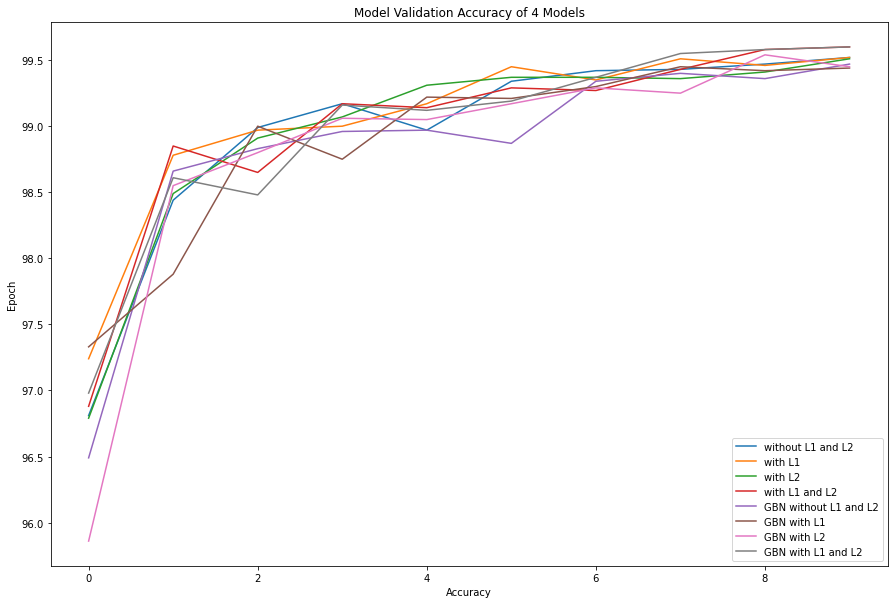

In [50]:

plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1.test_acc[:10])
ax.plot(model2.test_acc[:10])
ax.plot(model3.test_acc[:10])
ax.plot(model4.test_acc[:10])
ax.plot(model1.test_acc[10:])
ax.plot(model2.test_acc[10:])
ax.plot(model3.test_acc[10:])
ax.plot(model4.test_acc[10:])

ax.set(title="Model Validation Accuracy of 4 Models", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2','GBN without L1 and L2', 'GBN with L1', 'GBN with L2', 'GBN with L1 and L2'])
plt.savefig("Accuracy.png")
plt.show()

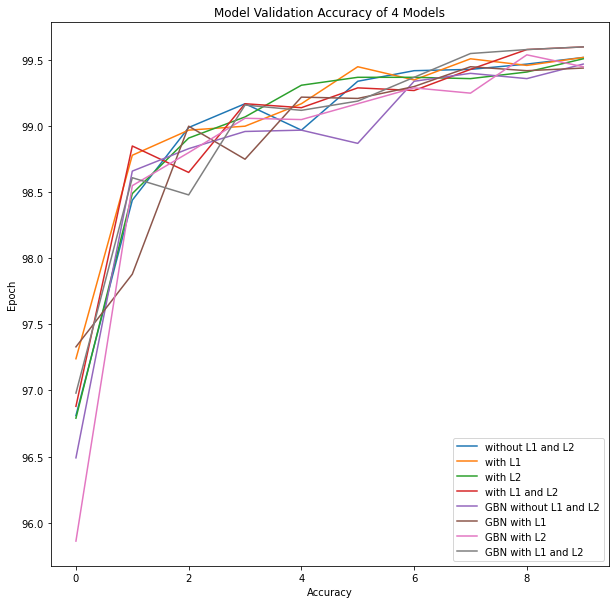

In [51]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(111)
ax.plot(model1.test_acc[:10])
ax.plot(model2.test_acc[:10])
ax.plot(model3.test_acc[:10])
ax.plot(model4.test_acc[:10])

ax.plot(model1.test_acc[10:])
ax.plot(model2.test_acc[10:])
ax.plot(model3.test_acc[10:])
ax.plot(model4.test_acc[10:])

ax.set(title="Model Validation Accuracy of 4 Models", xlabel="Accuracy", ylabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2','GBN without L1 and L2', 'GBN with L1', 'GBN with L2', 'GBN with L1 and L2'], loc='best')
plt.savefig("Accuracy.png")
plt.show()


## Plotting Validation Loss of Four Models

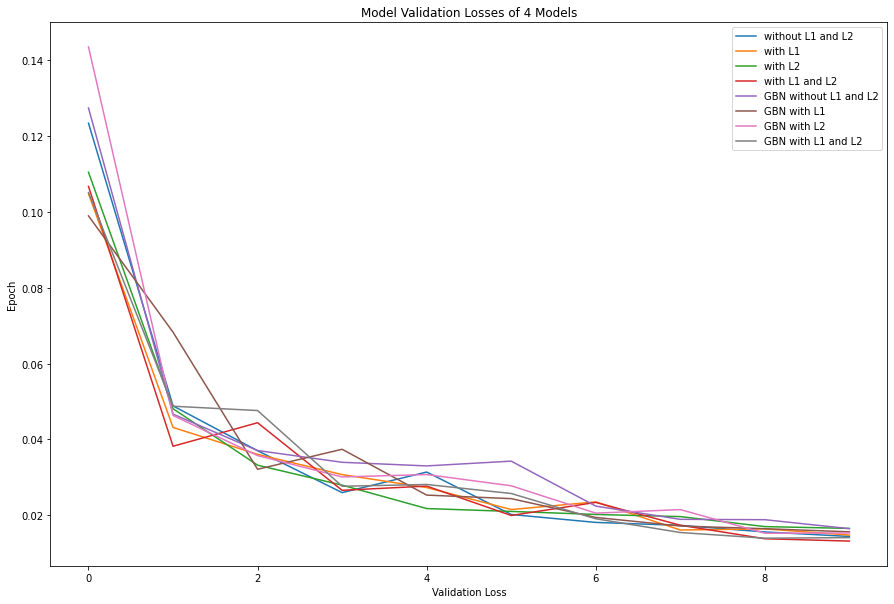

In [52]:
plt.figure(figsize=(15, 10))
ax = plt.subplot(111)
ax.plot(model1.test_losses[:10])
ax.plot(model2.test_losses[:10])
ax.plot(model3.test_losses[:10])
ax.plot(model4.test_losses[:10])

ax.plot(model1.test_losses[10:])
ax.plot(model2.test_losses[10:])
ax.plot(model3.test_losses[10:])
ax.plot(model4.test_losses[10:])

ax.set(title="Model Validation Losses of 4 Models", xlabel="Validation Loss", ylabel="Epoch")
ax.legend(['without L1 and L2', 'with L1', 'with L2', 'with L1 and L2', 'GBN without L1 and L2', 'GBN with L1', 'GBN with L2', 'GBN with L1 and L2'], loc='best')
plt.savefig("ValidationLoss.png")
plt.show()


## Function to plot Misclassified images

In [0]:
def PlotMisclassifiedImages(model, filename):
  
  model = model.to(device)
  # obtain one batch of test images
  dataiter = iter(test_loader)
  c=0
  fig = plt.figure(figsize=(14,14 ))
  
  while c<25:
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    
    output = model(images)  # get sample outputs

    _, preds = torch.max(output, 1)   # convert output probabilities to predicted class
    images = images.cpu().numpy() # prep images for display
    
    for idx in np.arange(128):
      if preds[idx]!=labels[idx] :
        ax = fig.add_subplot(5, 5, c+1, xticks=[], yticks=[])
        c=c+1
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("P-{} (T-{})".format(str(preds[idx].item()), str(labels[idx].item())), color="red")
        if c==25:
          break
    plt.savefig(filename)



In [54]:
#Load the first model with lowest validation loss
print("----Misclassified images by a Model without L1 and L2 regualatization----")
model.load_state_dict(torch.load("model1.pt")) 
PlotMisclassifiedImages(model, filename="WithoutL1andL2.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model without L1 and L2 regualatization----


RuntimeError: ignored

In [23]:
#Load the second model with lowest validation loss
print("----Misclassified images by a Model with L1 regualatization----")
model.load_state_dict(torch.load("model2.pt")) 
PlotMisclassifiedImages(model, filename="WithL1.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L1 regualatization----


RuntimeError: ignored

In [24]:
#Load the third model with lowest validation loss
print("----Misclassified images by a Model with L2 regualatization----")
model.load_state_dict(torch.load("model3.pt")) 
PlotMisclassifiedImages(model, filename="WithL2.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L2 regualatization----


RuntimeError: ignored

In [25]:
#Load the Fourth model with lowest validation loss
print("----Misclassified images by a Model with L1 and L2 regualatization----")
model.load_state_dict(torch.load("model4.pt")) 
PlotMisclassifiedImages(model, filename="WithL1andL2.png")  #25 misclassified images and save it in a file.

----Misclassified images by a Model with L1 and L2 regualatization----


RuntimeError: ignored